In [ ]:
!pip install --quiet imutils
!pip install --quiet torchsummary
!pip install --quiet timm

     |████████████████████████████████| 296kB 6.3MB/s 


In [ ]:
from torchsummary import summary
import pandas as pd
import random
import imutils
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms,models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2
from PIL import Image
from math import *
import time
import timm

In [ ]:
def top(df, column='order'):

    return df.sort_values(by='order', ascending=True)

In [ ]:
#from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/drive/MyDrive/IXIDB_csv/mra_axial.csv')
df = df.loc[:,['location','x','y','fn','order']]
#df_train,df_valid = train_test_split(df,test_size=0.2)
df_train = df[:1260]
df_valid = df[1260:]

In [ ]:
df_train[df_train['order']==1].mean(), df_train[df_train['order']==2].mean(),df_train[df_train['order']==3].mean()

(x        103.792857
 y        145.204762
 order      1.000000
 dtype: float64, x        152.809524
 y        143.847619
 order      2.000000
 dtype: float64, x        128.366667
 y        129.183333
 order      3.000000
 dtype: float64)

In [ ]:
#grouped = df.groupby('fn').apply(top,column='order')

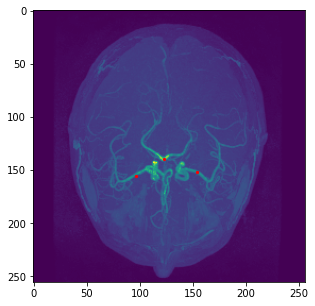

In [ ]:
landmarks = []
for i in range(3,6):
  landmarks.append([df_train.loc[i]['x'], df_train.loc[i]['y']])
landmarks = np.array(landmarks)

plt.figure(figsize=(5,5))
plt.imshow(cv2.imread('/content/drive/MyDrive/IXIDB_axial_png'+'/'+df_train.loc[3]['fn'],0))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')
plt.show()

In [ ]:
landmarks

array([[ 96, 156],
       [154, 152],
       [123, 140]])

In [ ]:
crop_w = (256-96)/2
crop_h =(256-96)/2

In [ ]:
landmarks = landmarks - np.array([[crop_w,crop_h]])
#temp = landmarks[0].copy()
#landmarks[0]=landmarks[1]
#landmarks[1]=temp
landmarks

array([[16., 76.],
       [74., 72.],
       [43., 60.]])

In [ ]:
landmarks[:,0] = 96-landmarks[:,0]
temp = landmarks[0].copy()
landmarks[0] = landmarks[1]
landmarks[1]=temp
landmarks

array([[22., 72.],
       [80., 76.],
       [53., 60.]])

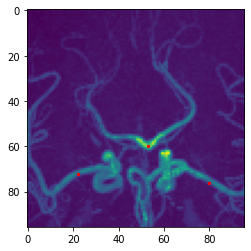

In [ ]:
#plt.figure(figsize=(5,5))
img = np.fliplr(cv2.imread('/content/drive/MyDrive/IXIDB_axial_png'+'/'+df_train.loc[3]['fn'],0)[80:176,80:176])
plt.imshow(img)
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')
plt.show()

In [ ]:
landmarks /=96

In [ ]:
transform = [
             [cos(radians(20)),-sin(radians(20))],
             [sin(radians(20)), cos(radians(20))]
]
landmarks-=0.5
landmarks = np.matmul(landmarks,transform)+0.5
landmarks

array([[0.33100495, 0.82755361],
       [0.91298675, 0.6600703 ],
       [0.59169484, 0.59964803]])

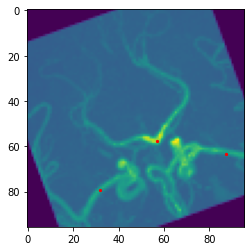

In [ ]:
#plt.figure(figsize=(5,5))
landmarks = landmarks*96
img = np.array(Image.fromarray(img))
img = imutils.rotate(img,20)
plt.imshow(img)
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')
plt.show()

- flip 빼도 결과가 잘 나옴...근데 flip을 적용해야 할 수도 있을텐데...ㅠㅠ
- 일단 hrnet에서 사용한 transform 참고해봐야 할 듯하고 일단 gnn적용 어떻게 할지 고민하기

In [ ]:
class Transforms_train():
    def __init__(self):
        pass

    def flip(self,image,landmarks):
      h,w = np.array(image).shape
      if random.random()>0.5:
        image = TF.hflip(image)
        landmarks[:,0] = 1-landmarks[:,0]-1/w
        temp = landmarks[0].clone()
        landmarks[0]=landmarks[1]
        landmarks[1]=temp
        
      '''if random.random()>0.5:
        landmarks[:,1] = image_height -landmarks[:,1] -1
        image = TF.vflip(image)'''

      return image ,landmarks

      
    def cropimg(self,image,landmarks):
      image_height, image_width = np.array(image).shape
      
      crop_height, crop_width = int(round(image_height/2.)), int(round(image_width/2.))
      crop_top = int(round((image_height - crop_height) / 2.))
      crop_left = int(round((image_width - crop_width) / 2.))

      image = TF.crop(image, crop_top, crop_left, crop_height, crop_width)
      
      img_shape = np.array(image).shape
      landmarks = torch.tensor(landmarks) - torch.tensor([[crop_left, crop_top]])
      landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])

      return image,landmarks

    def rotate(self, image, landmarks,angle):
      angle = random.uniform(-angle, +angle)
      scale = random.uniform(0.75,1.25)
      x_t, y_t = random.randint(-5,5), random.randint(-5,5)
      image_height, image_width = np.array(image).shape

      transformation_matrix = torch.tensor([
      [+cos(radians(angle)), -sin(radians(angle))], 
      [+sin(radians(angle)), +cos(radians(angle))]
      ])

      image = imutils.rotate(np.array(image), angle,None,scale)
      image = imutils.translate(np.array(image),x_t,y_t)

      landmarks = landmarks - 0.5
      new_landmarks = np.matmul(landmarks, transformation_matrix)
      new_landmarks = new_landmarks+np.array([[x_t/image_width, y_t/image_height]])
      new_landmarks = new_landmarks*scale

      new_landmarks = new_landmarks + 0.5

      return Image.fromarray(image), new_landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image, landmarks = self.cropimg(image, landmarks)
        #image, landmarks = self.flip(image, landmarks)
        image, landmarks = self.rotate(image, landmarks,angle=20)
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class Transforms_valid():
    def __init__(self):
        pass
    def cropimg(self,image,landmarks):
      image_height,image_width = np.array(image).shape
      
      crop_height, crop_width = int(round(image_height/2.)), int(round(image_width/2.))
      crop_top = int(round((image_height - crop_height) / 2.))
      crop_left = int(round((image_width - crop_width) / 2.))

      image = TF.crop(image, crop_top, crop_left, crop_height, crop_width)
      
      img_shape = np.array(image).shape
      landmarks = torch.tensor(landmarks) - torch.tensor([[crop_left, crop_top]])
      landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])

      return image,landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image,landmarks = self.cropimg(image, landmarks)   
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class axialDataset(torch.utils.data.Dataset):

    def __init__(self,df, transform=None,train=False):

        self.transform = transform
        
        if train :
          self.image_filenames = []
          self.landmarks = []
          self.df_train = df
          self.root_dir = '/content/drive/MyDrive/IXIDB_axial_png' # 사진폴더연결
          for filename in sorted(list(set(df_train['fn'].tolist()))):
              self.image_filenames.append(os.path.join(self.root_dir, filename))
              landmark = []

              for i,j in zip(df_train[df_train['fn']==filename]['x'],df_train[df_train['fn']==filename]['y']):
                  x_coordinate = i
                  y_coordinate = j
                  landmark.append([x_coordinate, y_coordinate])
              self.landmarks.append(landmark)
          self.landmarks = np.array(self.landmarks).astype('float32')

        else :
          self.image_filenames = []
          self.landmarks = []
          self.df_valid = df
          self.root_dir = '/content/drive/MyDrive/IXIDB_axial_png' #사진폴더
          for filename in sorted(list(set(df_valid['fn'].tolist()))):
              self.image_filenames.append(os.path.join(self.root_dir, filename))
              landmark = []

              for i,j in zip(df_valid[df_valid['fn']==filename]['x'],df_valid[df_valid['fn']==filename]['y']):
                  x_coordinate = i
                  y_coordinate = j
                  landmark.append([x_coordinate, y_coordinate])
              self.landmarks.append(landmark)

          self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks)

        landmarks = landmarks - 0.5

        return image, landmarks

In [ ]:
dataset_train = axialDataset(df_train,Transforms_train(),True)
dataset_valid = axialDataset(df_valid,Transforms_valid(),False)

In [ ]:
len(dataset_train),len(dataset_valid)

(420, 37)

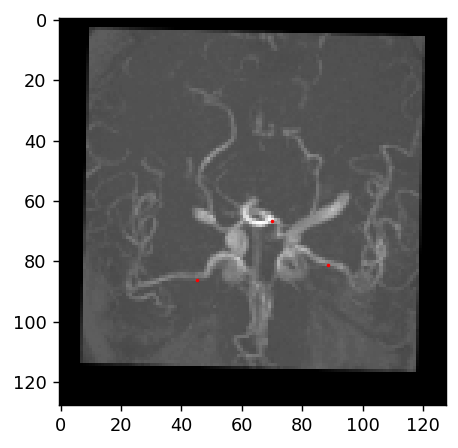

In [ ]:
image, points = dataset_train[4]
points = (points+0.5)*128
plt.figure(dpi=128)
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.scatter(points[:,0], points[:,1], s=1,c='r')

# 나오는 결과 포인트*128+128하면 원래값으로 돌아옴!

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=8, shuffle=True, num_workers=2)
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([8, 1, 128, 128])
torch.Size([8, 3, 2])


In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=6):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
network.load_state_dict(torch.load('/content/drive/MyDrive/IXIDB_axial_model_save/face_landmarks.pth'))

<All keys matched successfully>

In [ ]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

In [ ]:
save_output = SaveOutput()

hook_handles = []

for layer in network.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

In [ ]:
images = images.cuda()
#predictions = network(images)

In [ ]:
len(save_output.outputs)

20

In [ ]:
for i in range(len(save_output.outputs)):
  print(i+1)
  print(save_output.outputs[i].shape)

1
torch.Size([8, 64, 64, 64])
2
torch.Size([8, 64, 32, 32])
3
torch.Size([8, 64, 32, 32])
4
torch.Size([8, 64, 32, 32])
5
torch.Size([8, 64, 32, 32])
6
torch.Size([8, 128, 16, 16])
7
torch.Size([8, 128, 16, 16])
8
torch.Size([8, 128, 16, 16])
9
torch.Size([8, 128, 16, 16])
10
torch.Size([8, 128, 16, 16])
11
torch.Size([8, 256, 8, 8])
12
torch.Size([8, 256, 8, 8])
13
torch.Size([8, 256, 8, 8])
14
torch.Size([8, 256, 8, 8])
15
torch.Size([8, 256, 8, 8])
16
torch.Size([8, 512, 4, 4])
17
torch.Size([8, 512, 4, 4])
18
torch.Size([8, 512, 4, 4])
19
torch.Size([8, 512, 4, 4])
20
torch.Size([8, 512, 4, 4])


In [ ]:
a = torch.cat((F.interpolate(save_output.outputs[19],[8,8],mode='bilinear',align_corners=False),save_output.outputs[14]),dim=-1)
b= torch.cat((F.interpolate(a,[16,16],mode='bilinear',align_corners=False),save_output.outputs[9]),dim=-1)
c = torch.cat((F.interpolate(b,[32,32],mode='bilinear',align_corners=False),save_output.outputs[4]),dim=-1)
d = F.interpolate(c,[128,128],mode='bilinear',align_corners=False)
d.shape

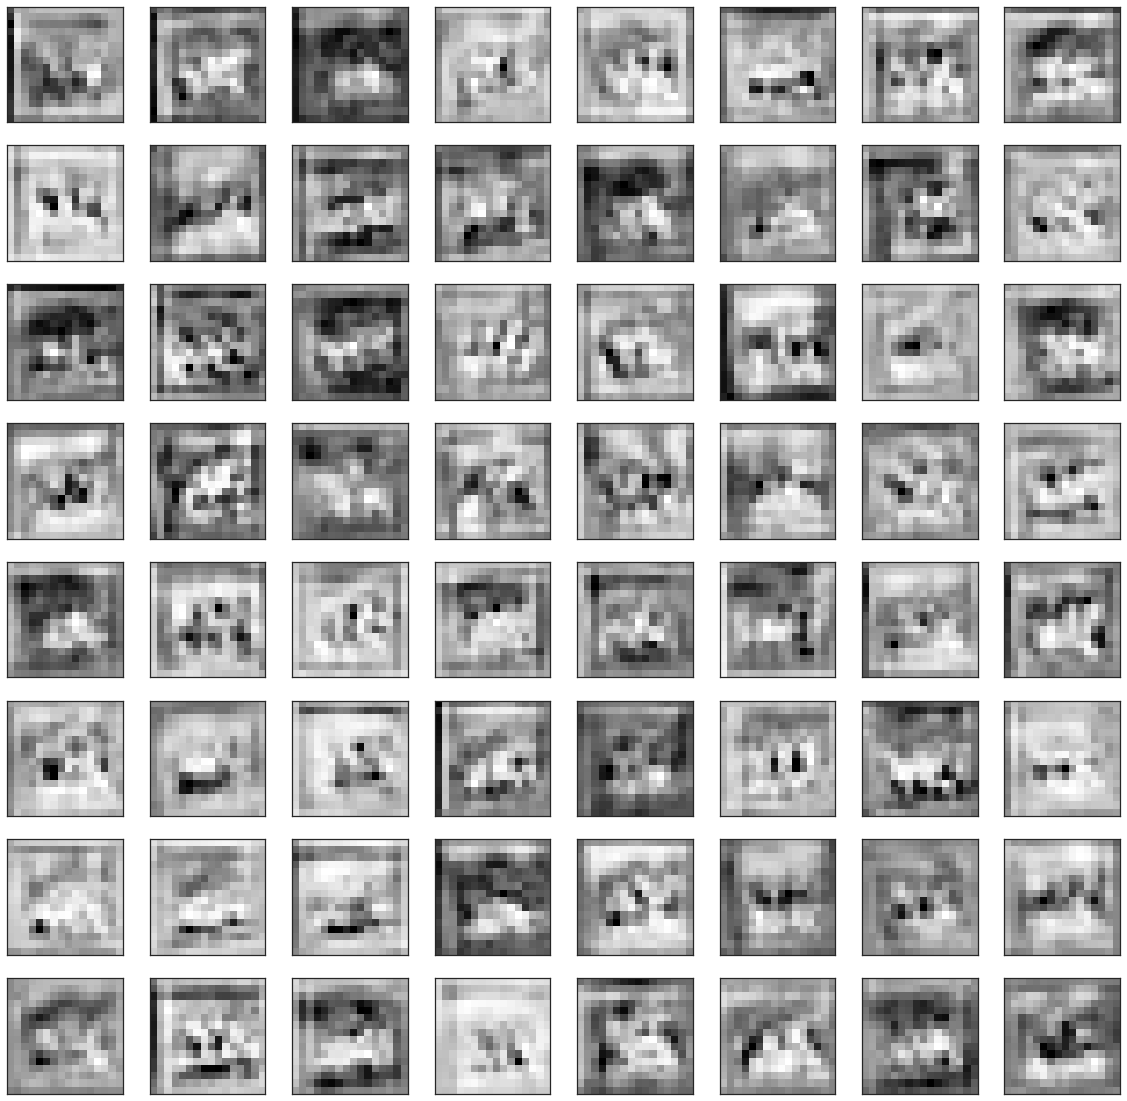

In [ ]:
def module_output_to_numpy(tensor):
    return tensor.detach().to('cpu').numpy()    

images = module_output_to_numpy(save_output.outputs[9])

with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 20), frameon=False)
    for idx in range(64):
        plt.subplot(8, 8, idx+1)
        plt.imshow(images[0, idx])
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

In [ ]:
#Helper function
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.AdamW(network.parameters(), lr=3e-3,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3,threshold=e-10,factor=0.9)

loss_min = np.inf
num_epochs = 200

Valid Steps: 5/5  Loss: 0.0046 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0035  Valid Loss: 0.0046
--------------------------------------------------


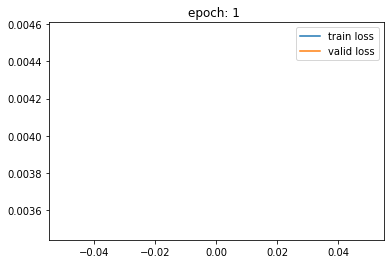

Valid Steps: 5/5  Loss: 0.0021 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0028  Valid Loss: 0.0021
--------------------------------------------------


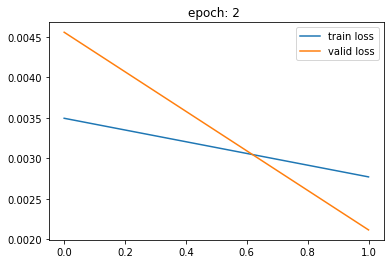


Minimum Validation Loss of 0.0021 at epoch 2/200
Model Saved

Valid Steps: 5/5  Loss: 0.0017 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0029  Valid Loss: 0.0017
--------------------------------------------------


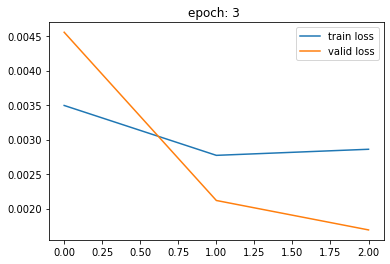


Minimum Validation Loss of 0.0017 at epoch 3/200
Model Saved

Valid Steps: 5/5  Loss: 0.0027 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0046  Valid Loss: 0.0027
--------------------------------------------------


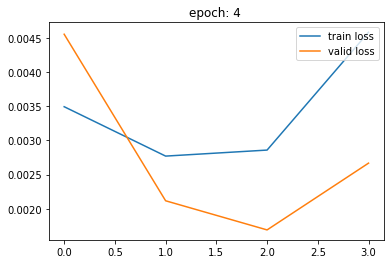

Valid Steps: 5/5  Loss: 0.0018 
--------------------------------------------------
Epoch: 5  Train Loss: 0.0037  Valid Loss: 0.0018
--------------------------------------------------


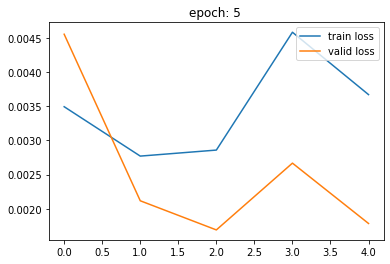

Valid Steps: 5/5  Loss: 0.0028 
--------------------------------------------------
Epoch: 6  Train Loss: 0.0029  Valid Loss: 0.0028
--------------------------------------------------


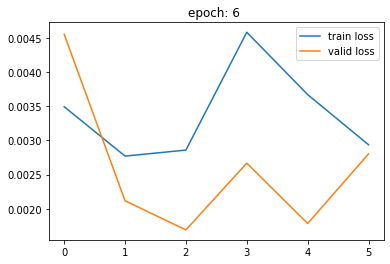

Valid Steps: 5/5  Loss: 0.0029 
--------------------------------------------------
Epoch: 7  Train Loss: 0.0037  Valid Loss: 0.0029
--------------------------------------------------


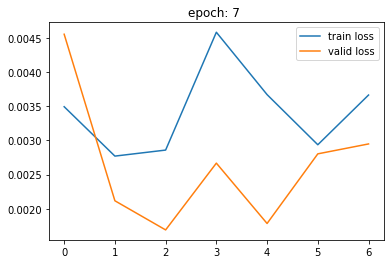

Valid Steps: 5/5  Loss: 0.0045 
--------------------------------------------------
Epoch: 8  Train Loss: 0.0027  Valid Loss: 0.0045
--------------------------------------------------


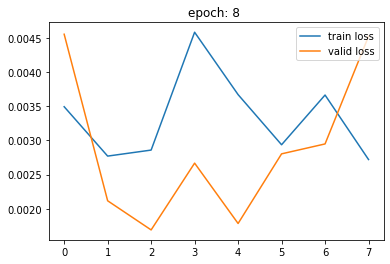

Train Steps: 10/53  Loss: 0.0030 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-5eshuzc2'


Valid Steps: 5/5  Loss: 0.0026 
--------------------------------------------------
Epoch: 9  Train Loss: 0.0032  Valid Loss: 0.0026
--------------------------------------------------


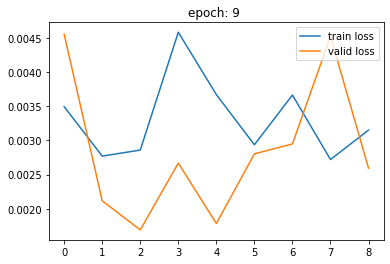

Valid Steps: 5/5  Loss: 0.0018 
--------------------------------------------------
Epoch: 10  Train Loss: 0.0023  Valid Loss: 0.0018
--------------------------------------------------


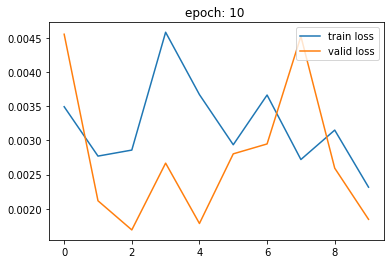

Valid Steps: 5/5  Loss: 0.0023 
--------------------------------------------------
Epoch: 11  Train Loss: 0.0025  Valid Loss: 0.0023
--------------------------------------------------


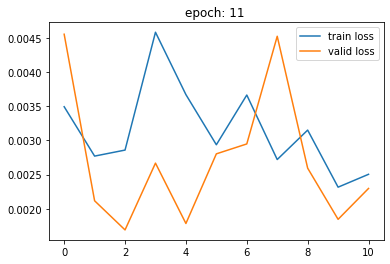

Valid Steps: 5/5  Loss: 0.0038 
--------------------------------------------------
Epoch: 12  Train Loss: 0.0031  Valid Loss: 0.0038
--------------------------------------------------


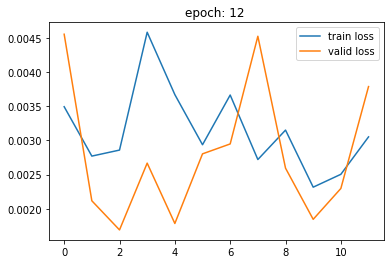

Valid Steps: 5/5  Loss: 0.0029 
--------------------------------------------------
Epoch: 13  Train Loss: 0.0023  Valid Loss: 0.0029
--------------------------------------------------


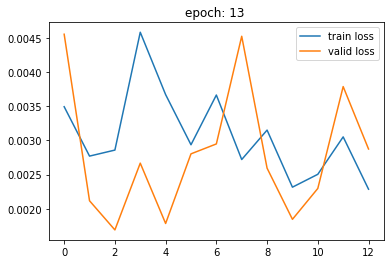

Valid Steps: 5/5  Loss: 0.0027 
--------------------------------------------------
Epoch: 14  Train Loss: 0.0025  Valid Loss: 0.0027
--------------------------------------------------


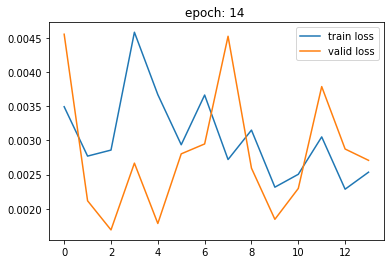

Valid Steps: 5/5  Loss: 0.0048 
--------------------------------------------------
Epoch: 15  Train Loss: 0.0028  Valid Loss: 0.0048
--------------------------------------------------


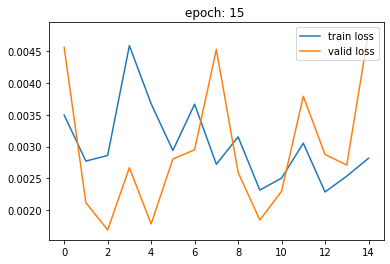

Valid Steps: 5/5  Loss: 0.0027 
--------------------------------------------------
Epoch: 16  Train Loss: 0.0030  Valid Loss: 0.0027
--------------------------------------------------


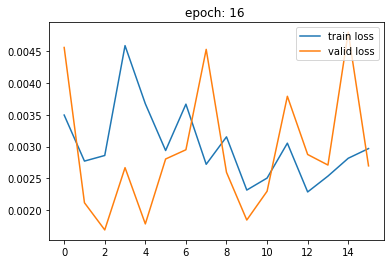

Valid Steps: 5/5  Loss: 0.0014 
--------------------------------------------------
Epoch: 17  Train Loss: 0.0018  Valid Loss: 0.0014
--------------------------------------------------


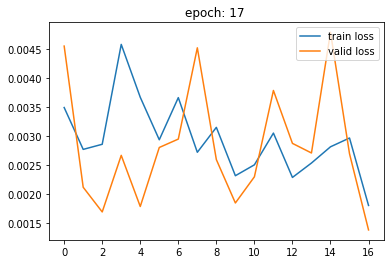


Minimum Validation Loss of 0.0014 at epoch 17/200
Model Saved

Valid Steps: 5/5  Loss: 0.0026 
--------------------------------------------------
Epoch: 18  Train Loss: 0.0017  Valid Loss: 0.0026
--------------------------------------------------


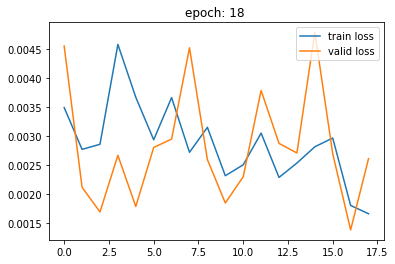

Valid Steps: 5/5  Loss: 0.0043 
--------------------------------------------------
Epoch: 19  Train Loss: 0.0021  Valid Loss: 0.0043
--------------------------------------------------


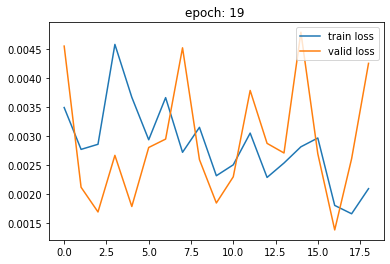

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 20  Train Loss: 0.0026  Valid Loss: 0.0012
--------------------------------------------------


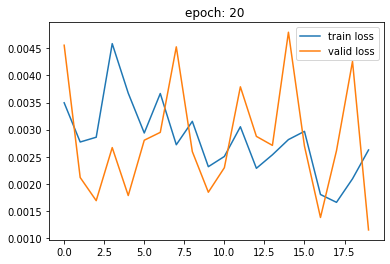


Minimum Validation Loss of 0.0012 at epoch 20/200
Model Saved

Valid Steps: 5/5  Loss: 0.0035 
--------------------------------------------------
Epoch: 21  Train Loss: 0.0020  Valid Loss: 0.0035
--------------------------------------------------


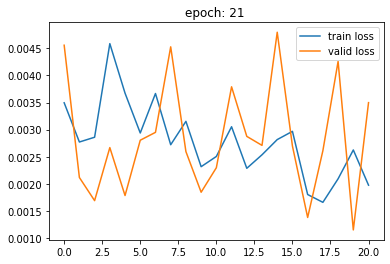

Train Steps: 20/53  Loss: 0.0015 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-pxq__qkr'


Valid Steps: 5/5  Loss: 0.0015 
--------------------------------------------------
Epoch: 22  Train Loss: 0.0014  Valid Loss: 0.0015
--------------------------------------------------


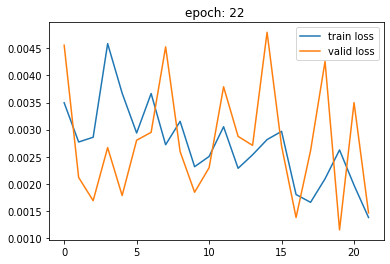

Train Steps: 41/53  Loss: 0.0017 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-_axwg7qk'


Valid Steps: 5/5  Loss: 0.0010 
--------------------------------------------------
Epoch: 23  Train Loss: 0.0018  Valid Loss: 0.0010
--------------------------------------------------


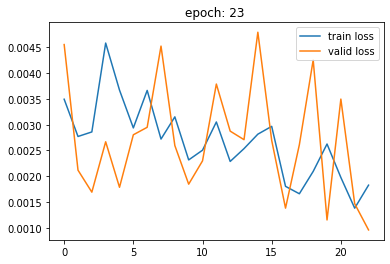


Minimum Validation Loss of 0.0010 at epoch 23/200
Model Saved

Valid Steps: 5/5  Loss: 0.0022 
--------------------------------------------------
Epoch: 24  Train Loss: 0.0019  Valid Loss: 0.0022
--------------------------------------------------


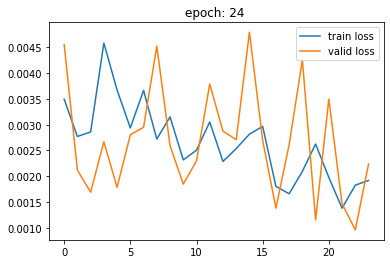

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 25  Train Loss: 0.0016  Valid Loss: 0.0005
--------------------------------------------------


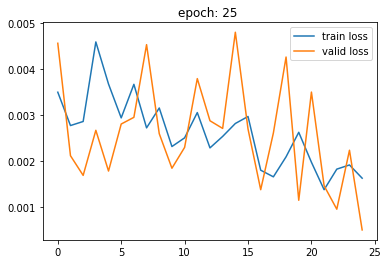


Minimum Validation Loss of 0.0005 at epoch 25/200
Model Saved

Valid Steps: 5/5  Loss: 0.0010 
--------------------------------------------------
Epoch: 26  Train Loss: 0.0013  Valid Loss: 0.0010
--------------------------------------------------


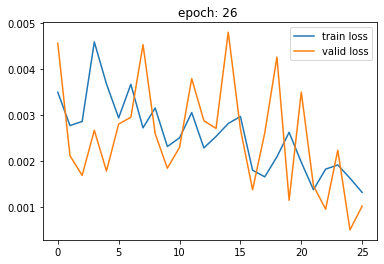

Valid Steps: 5/5  Loss: 0.0007 
--------------------------------------------------
Epoch: 27  Train Loss: 0.0013  Valid Loss: 0.0007
--------------------------------------------------


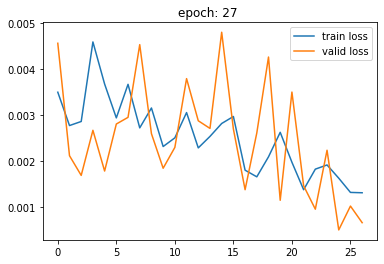

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 28  Train Loss: 0.0011  Valid Loss: 0.0006
--------------------------------------------------


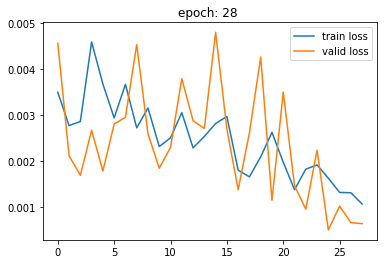

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 29  Train Loss: 0.0012  Valid Loss: 0.0009
--------------------------------------------------


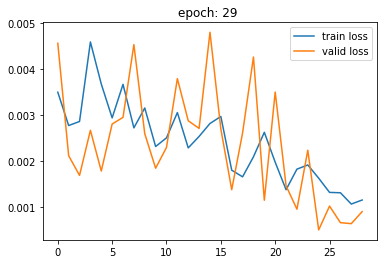

Valid Steps: 5/5  Loss: 0.0011 
--------------------------------------------------
Epoch: 30  Train Loss: 0.0017  Valid Loss: 0.0011
--------------------------------------------------


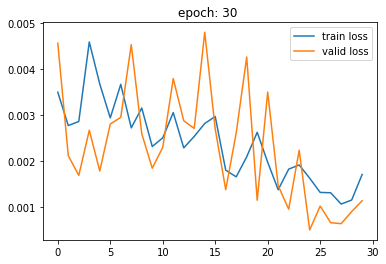

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 31  Train Loss: 0.0018  Valid Loss: 0.0009
--------------------------------------------------


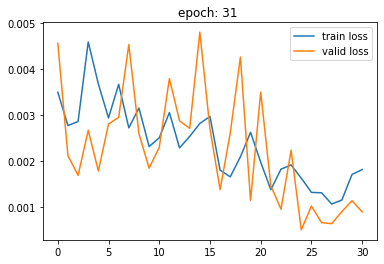

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 32  Train Loss: 0.0011  Valid Loss: 0.0006
--------------------------------------------------


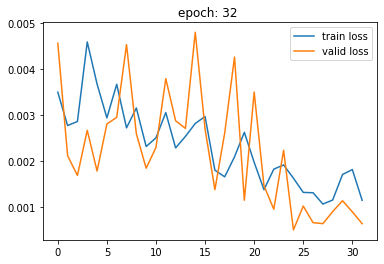

Valid Steps: 5/5  Loss: 0.0024 
--------------------------------------------------
Epoch: 33  Train Loss: 0.0015  Valid Loss: 0.0024
--------------------------------------------------


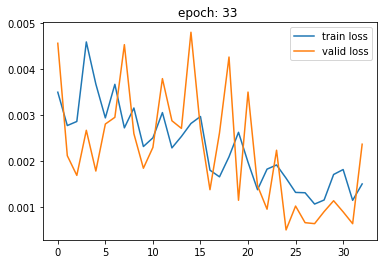

Valid Steps: 5/5  Loss: 0.0027 
--------------------------------------------------
Epoch: 34  Train Loss: 0.0017  Valid Loss: 0.0027
--------------------------------------------------


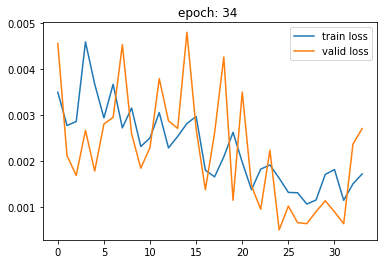

Valid Steps: 5/5  Loss: 0.0007 
--------------------------------------------------
Epoch: 35  Train Loss: 0.0012  Valid Loss: 0.0007
--------------------------------------------------


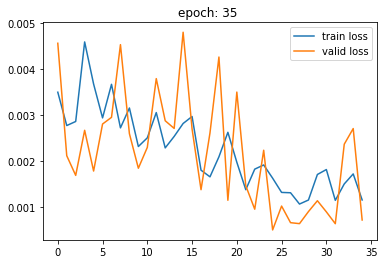

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 36  Train Loss: 0.0013  Valid Loss: 0.0012
--------------------------------------------------


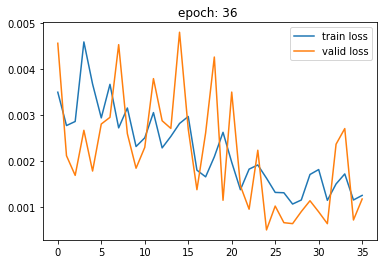

Valid Steps: 5/5  Loss: 0.0007 
--------------------------------------------------
Epoch: 37  Train Loss: 0.0011  Valid Loss: 0.0007
--------------------------------------------------


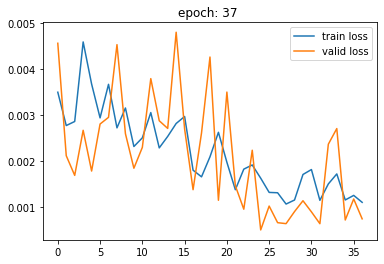

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 38  Train Loss: 0.0014  Valid Loss: 0.0006
--------------------------------------------------


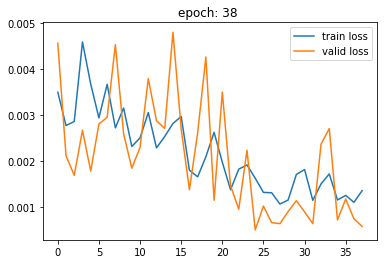

Valid Steps: 5/5  Loss: 0.0023 
--------------------------------------------------
Epoch: 39  Train Loss: 0.0009  Valid Loss: 0.0023
--------------------------------------------------


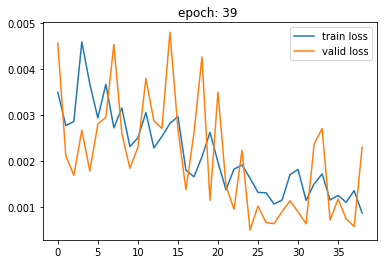

Valid Steps: 5/5  Loss: 0.0010 
--------------------------------------------------
Epoch: 40  Train Loss: 0.0010  Valid Loss: 0.0010
--------------------------------------------------


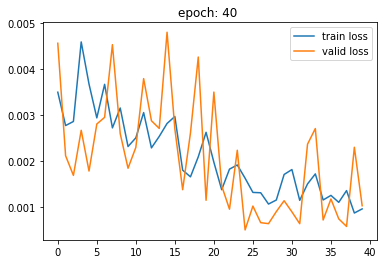

Valid Steps: 5/5  Loss: 0.0016 
--------------------------------------------------
Epoch: 41  Train Loss: 0.0014  Valid Loss: 0.0016
--------------------------------------------------


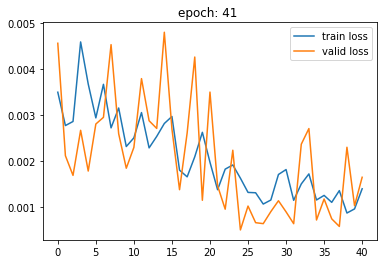

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 42  Train Loss: 0.0015  Valid Loss: 0.0008
--------------------------------------------------


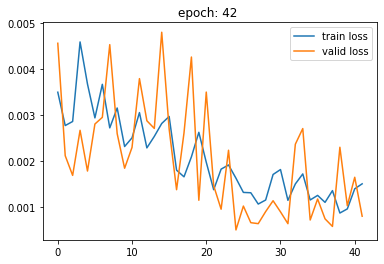

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 43  Train Loss: 0.0011  Valid Loss: 0.0008
--------------------------------------------------


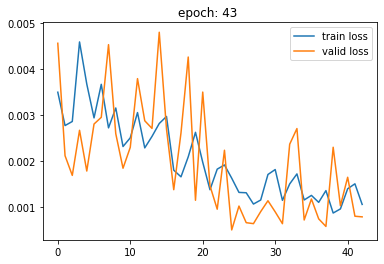

Valid Steps: 5/5  Loss: 0.0016 
--------------------------------------------------
Epoch: 44  Train Loss: 0.0011  Valid Loss: 0.0016
--------------------------------------------------


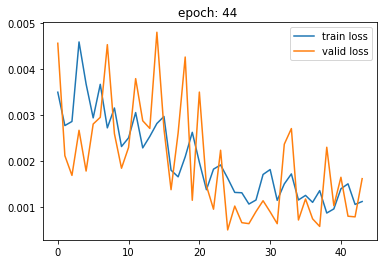

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 45  Train Loss: 0.0011  Valid Loss: 0.0009
--------------------------------------------------


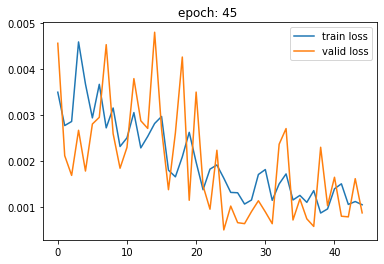

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 46  Train Loss: 0.0013  Valid Loss: 0.0008
--------------------------------------------------


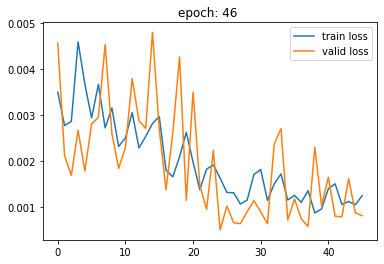

Valid Steps: 5/5  Loss: 0.0014 
--------------------------------------------------
Epoch: 47  Train Loss: 0.0010  Valid Loss: 0.0014
--------------------------------------------------


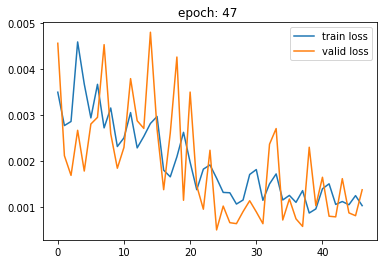

Valid Steps: 5/5  Loss: 0.0017 
--------------------------------------------------
Epoch: 48  Train Loss: 0.0010  Valid Loss: 0.0017
--------------------------------------------------


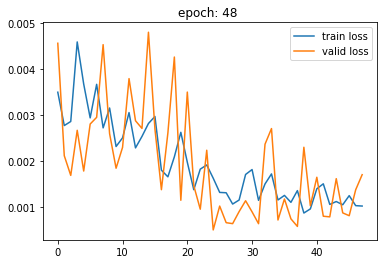

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 49  Train Loss: 0.0009  Valid Loss: 0.0009
--------------------------------------------------


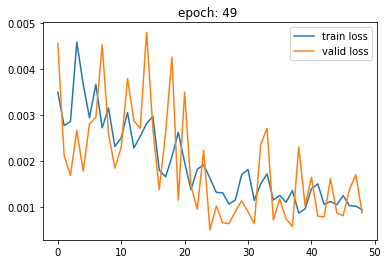

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 50  Train Loss: 0.0010  Valid Loss: 0.0012
--------------------------------------------------


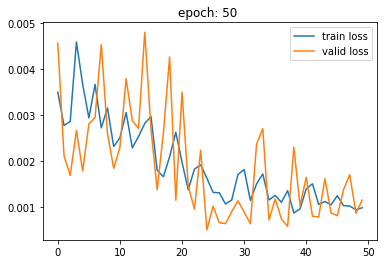

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 51  Train Loss: 0.0008  Valid Loss: 0.0005
--------------------------------------------------


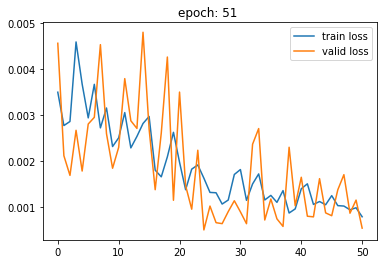

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 52  Train Loss: 0.0009  Valid Loss: 0.0009
--------------------------------------------------


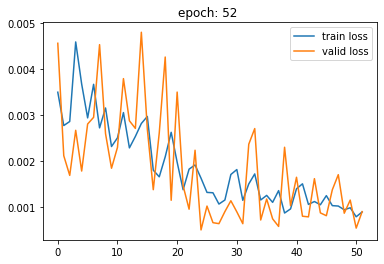

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 53  Train Loss: 0.0009  Valid Loss: 0.0012
--------------------------------------------------


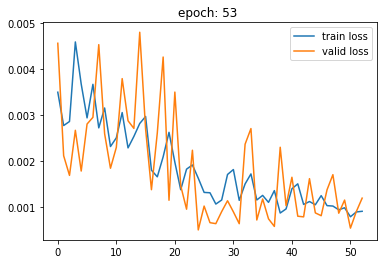

Valid Steps: 5/5  Loss: 0.0017 
--------------------------------------------------
Epoch: 54  Train Loss: 0.0009  Valid Loss: 0.0017
--------------------------------------------------


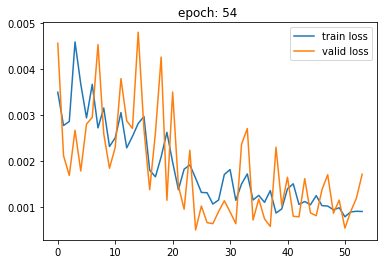

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 55  Train Loss: 0.0009  Valid Loss: 0.0005
--------------------------------------------------


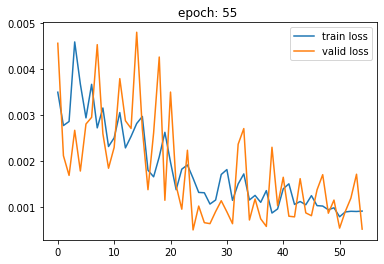

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 56  Train Loss: 0.0009  Valid Loss: 0.0005
--------------------------------------------------


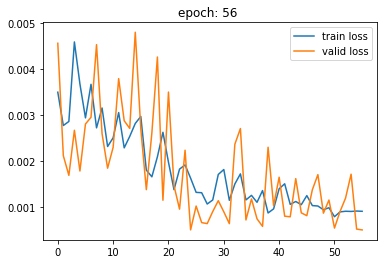


Minimum Validation Loss of 0.0005 at epoch 56/200
Model Saved

Valid Steps: 5/5  Loss: 0.0011 
--------------------------------------------------
Epoch: 57  Train Loss: 0.0006  Valid Loss: 0.0011
--------------------------------------------------


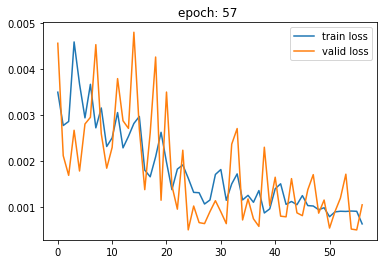

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 58  Train Loss: 0.0006  Valid Loss: 0.0006
--------------------------------------------------


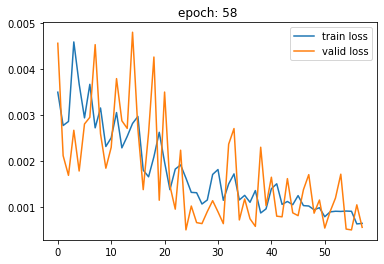

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 59  Train Loss: 0.0006  Valid Loss: 0.0012
--------------------------------------------------


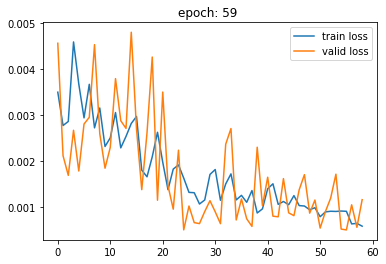

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 60  Train Loss: 0.0008  Valid Loss: 0.0004
--------------------------------------------------


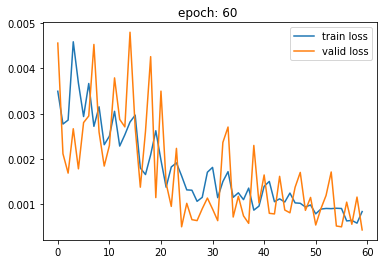


Minimum Validation Loss of 0.0004 at epoch 60/200
Model Saved

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 61  Train Loss: 0.0006  Valid Loss: 0.0012
--------------------------------------------------


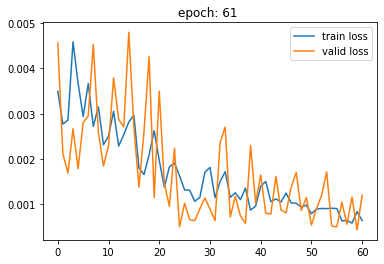

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 62  Train Loss: 0.0007  Valid Loss: 0.0004
--------------------------------------------------


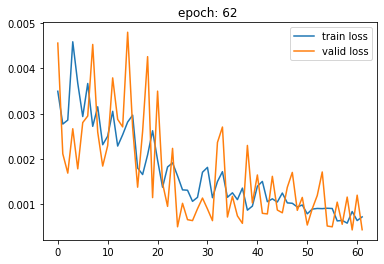

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 63  Train Loss: 0.0005  Valid Loss: 0.0004
--------------------------------------------------


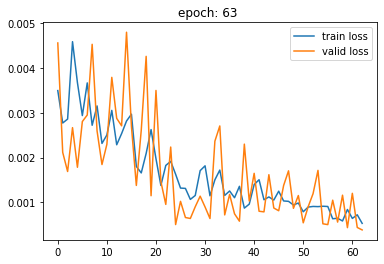


Minimum Validation Loss of 0.0004 at epoch 63/200
Model Saved

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 64  Train Loss: 0.0006  Valid Loss: 0.0005
--------------------------------------------------


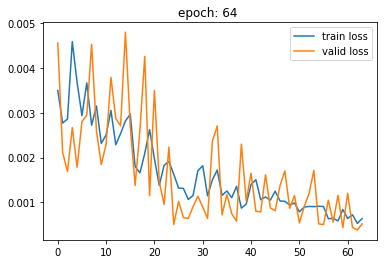

Valid Steps: 5/5  Loss: 0.0013 
--------------------------------------------------
Epoch: 65  Train Loss: 0.0005  Valid Loss: 0.0013
--------------------------------------------------


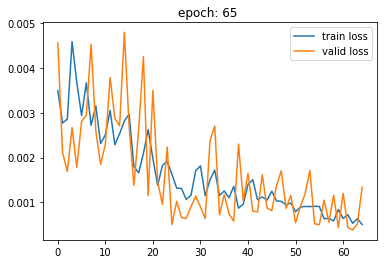

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 66  Train Loss: 0.0007  Valid Loss: 0.0004
--------------------------------------------------


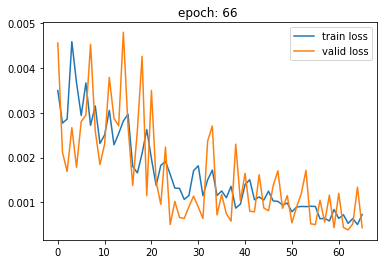

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 67  Train Loss: 0.0005  Valid Loss: 0.0006
--------------------------------------------------


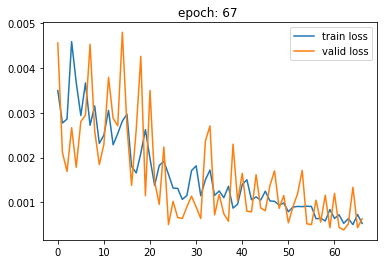

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 68  Train Loss: 0.0006  Valid Loss: 0.0012
--------------------------------------------------


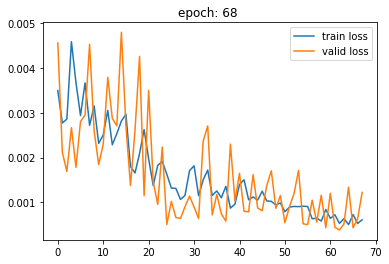

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 69  Train Loss: 0.0006  Valid Loss: 0.0008
--------------------------------------------------


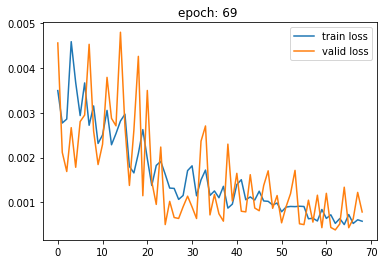

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 70  Train Loss: 0.0004  Valid Loss: 0.0005
--------------------------------------------------


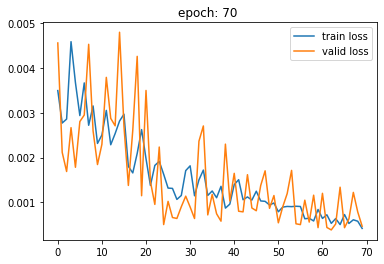

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 71  Train Loss: 0.0006  Valid Loss: 0.0009
--------------------------------------------------


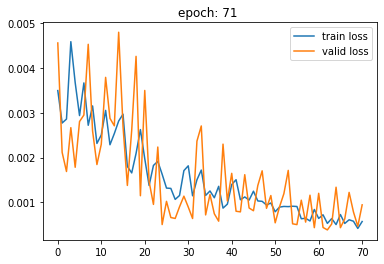

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 72  Train Loss: 0.0007  Valid Loss: 0.0008
--------------------------------------------------


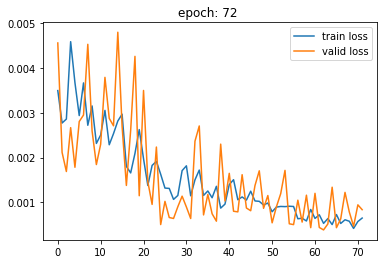

Valid Steps: 5/5  Loss: 0.0010 
--------------------------------------------------
Epoch: 73  Train Loss: 0.0006  Valid Loss: 0.0010
--------------------------------------------------


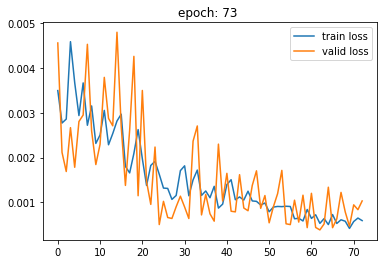

Valid Steps: 5/5  Loss: 0.0013 
--------------------------------------------------
Epoch: 74  Train Loss: 0.0005  Valid Loss: 0.0013
--------------------------------------------------


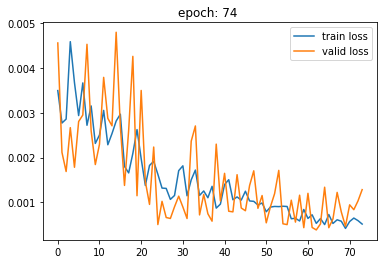

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 75  Train Loss: 0.0007  Valid Loss: 0.0006
--------------------------------------------------


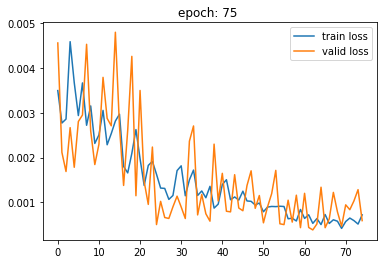

Valid Steps: 5/5  Loss: 0.0007 
--------------------------------------------------
Epoch: 76  Train Loss: 0.0004  Valid Loss: 0.0007
--------------------------------------------------


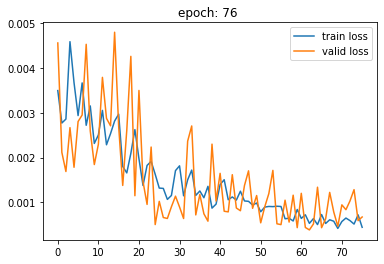

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 77  Train Loss: 0.0006  Valid Loss: 0.0005
--------------------------------------------------


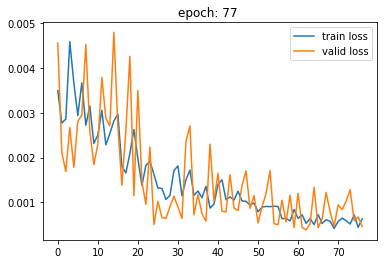

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 78  Train Loss: 0.0004  Valid Loss: 0.0005
--------------------------------------------------


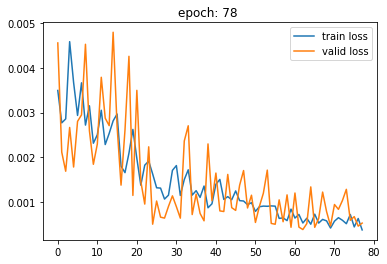

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 79  Train Loss: 0.0007  Valid Loss: 0.0005
--------------------------------------------------


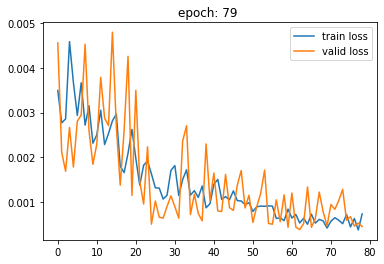

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 80  Train Loss: 0.0006  Valid Loss: 0.0006
--------------------------------------------------


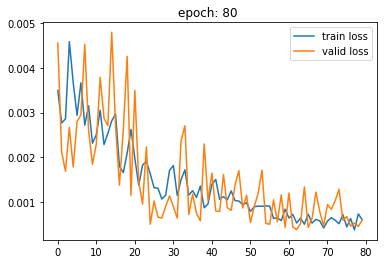

Valid Steps: 5/5  Loss: 0.0013 
--------------------------------------------------
Epoch: 81  Train Loss: 0.0008  Valid Loss: 0.0013
--------------------------------------------------


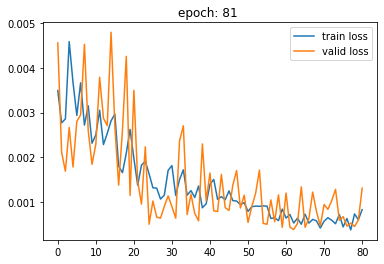

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 82  Train Loss: 0.0007  Valid Loss: 0.0005
--------------------------------------------------


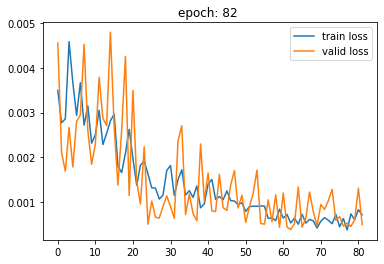

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 83  Train Loss: 0.0006  Valid Loss: 0.0005
--------------------------------------------------


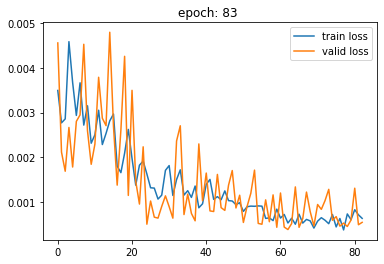

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 84  Train Loss: 0.0006  Valid Loss: 0.0006
--------------------------------------------------


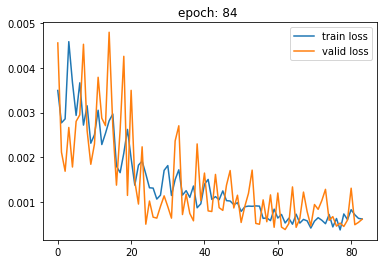

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 85  Train Loss: 0.0006  Valid Loss: 0.0005
--------------------------------------------------


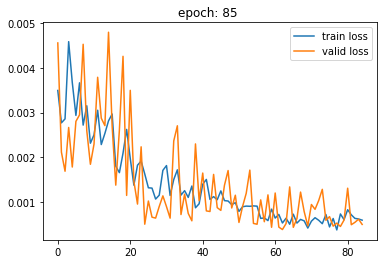

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 86  Train Loss: 0.0005  Valid Loss: 0.0008
--------------------------------------------------


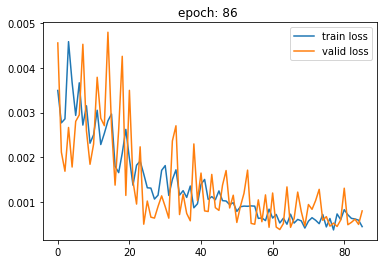

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 87  Train Loss: 0.0005  Valid Loss: 0.0004
--------------------------------------------------


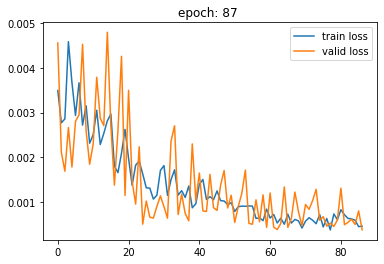


Minimum Validation Loss of 0.0004 at epoch 87/200
Model Saved

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 88  Train Loss: 0.0004  Valid Loss: 0.0003
--------------------------------------------------


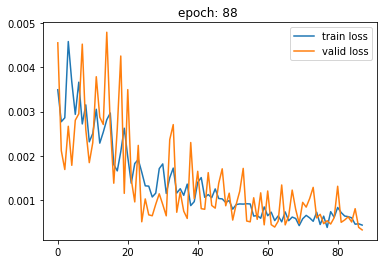


Minimum Validation Loss of 0.0003 at epoch 88/200
Model Saved

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 89  Train Loss: 0.0004  Valid Loss: 0.0009
--------------------------------------------------


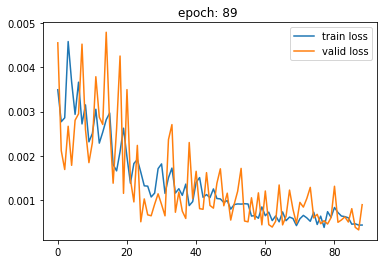

Valid Steps: 5/5  Loss: 0.0010 
--------------------------------------------------
Epoch: 90  Train Loss: 0.0006  Valid Loss: 0.0010
--------------------------------------------------


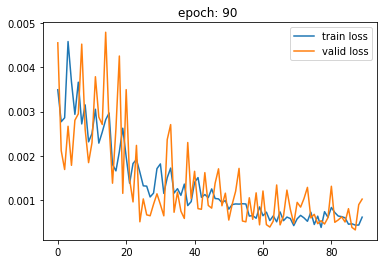

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 91  Train Loss: 0.0005  Valid Loss: 0.0009
--------------------------------------------------


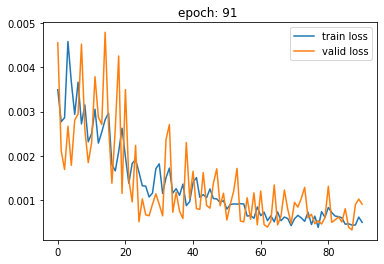

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 92  Train Loss: 0.0006  Valid Loss: 0.0004
--------------------------------------------------


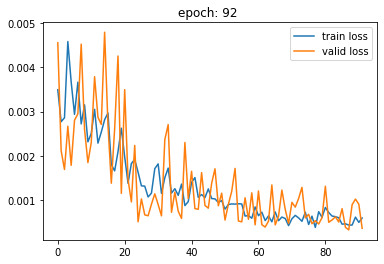

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 93  Train Loss: 0.0005  Valid Loss: 0.0008
--------------------------------------------------


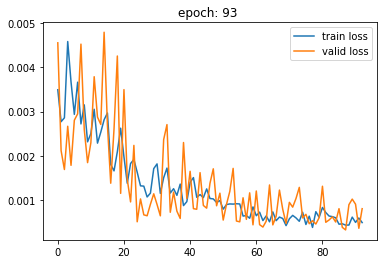

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 94  Train Loss: 0.0005  Valid Loss: 0.0009
--------------------------------------------------


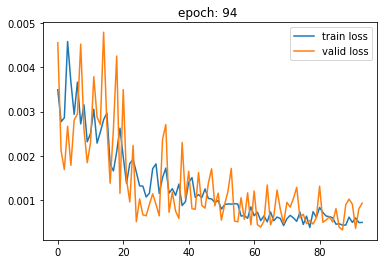

Train Steps: 51/53  Loss: 0.0007 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-csxo8wen'


Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 95  Train Loss: 0.0006  Valid Loss: 0.0004
--------------------------------------------------


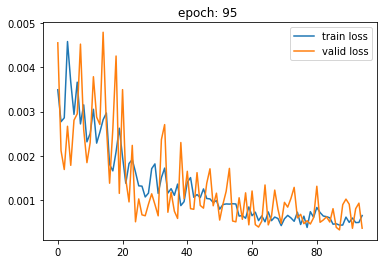

Train Steps: 29/53  Loss: 0.0004 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-plyix468'


Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 96  Train Loss: 0.0005  Valid Loss: 0.0006
--------------------------------------------------


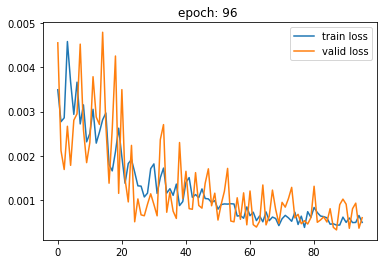

Valid Steps: 5/5  Loss: 0.0011 
--------------------------------------------------
Epoch: 97  Train Loss: 0.0006  Valid Loss: 0.0011
--------------------------------------------------


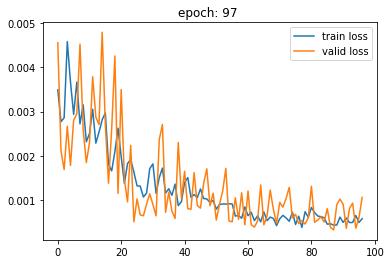

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 98  Train Loss: 0.0005  Valid Loss: 0.0003
--------------------------------------------------


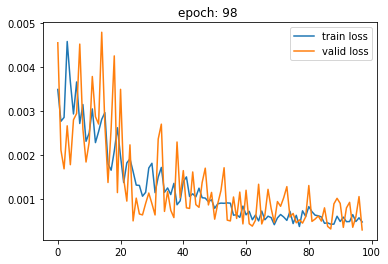


Minimum Validation Loss of 0.0003 at epoch 98/200
Model Saved

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 99  Train Loss: 0.0005  Valid Loss: 0.0003
--------------------------------------------------


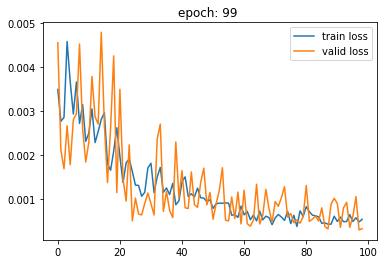

Valid Steps: 5/5  Loss: 0.0012 
--------------------------------------------------
Epoch: 100  Train Loss: 0.0006  Valid Loss: 0.0012
--------------------------------------------------


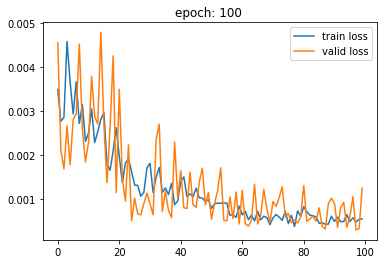

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 101  Train Loss: 0.0005  Valid Loss: 0.0003
--------------------------------------------------


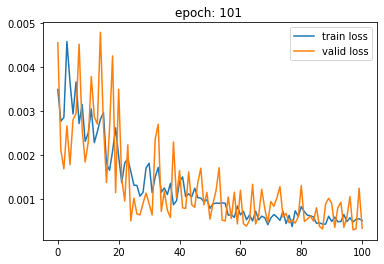

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 102  Train Loss: 0.0004  Valid Loss: 0.0006
--------------------------------------------------


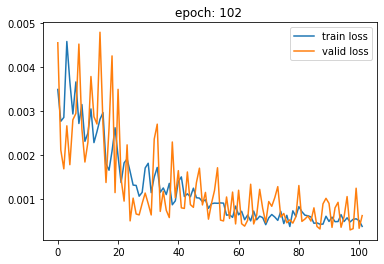

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 103  Train Loss: 0.0003  Valid Loss: 0.0003
--------------------------------------------------


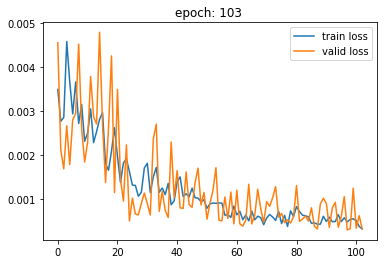

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 104  Train Loss: 0.0005  Valid Loss: 0.0005
--------------------------------------------------


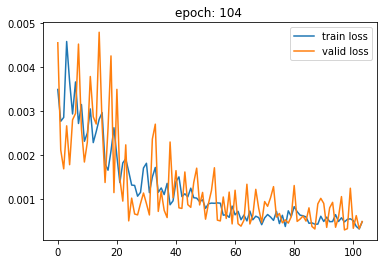

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 105  Train Loss: 0.0005  Valid Loss: 0.0004
--------------------------------------------------


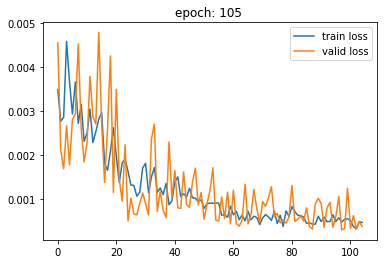

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 106  Train Loss: 0.0004  Valid Loss: 0.0003
--------------------------------------------------


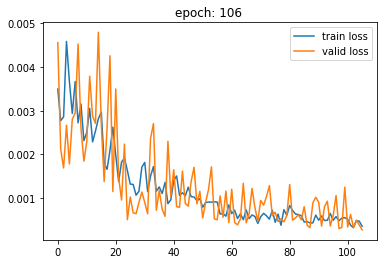


Minimum Validation Loss of 0.0003 at epoch 106/200
Model Saved

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 107  Train Loss: 0.0004  Valid Loss: 0.0004
--------------------------------------------------


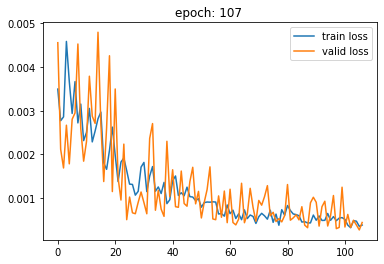

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 108  Train Loss: 0.0004  Valid Loss: 0.0004
--------------------------------------------------


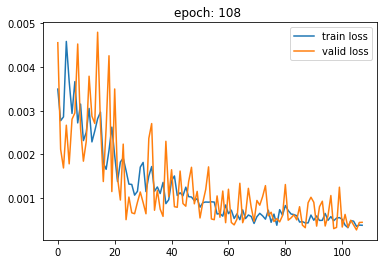

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 109  Train Loss: 0.0004  Valid Loss: 0.0002
--------------------------------------------------


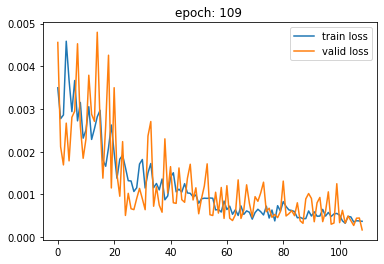


Minimum Validation Loss of 0.0002 at epoch 109/200
Model Saved

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 110  Train Loss: 0.0003  Valid Loss: 0.0005
--------------------------------------------------


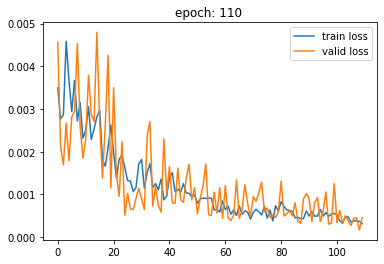

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 111  Train Loss: 0.0005  Valid Loss: 0.0003
--------------------------------------------------


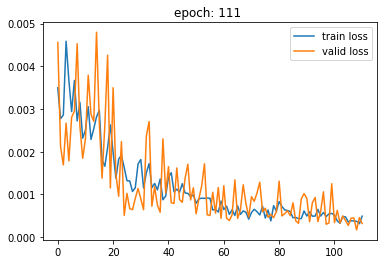

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 112  Train Loss: 0.0004  Valid Loss: 0.0005
--------------------------------------------------


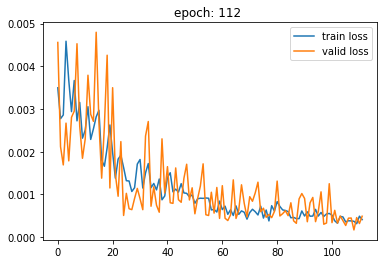

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 113  Train Loss: 0.0005  Valid Loss: 0.0009
--------------------------------------------------


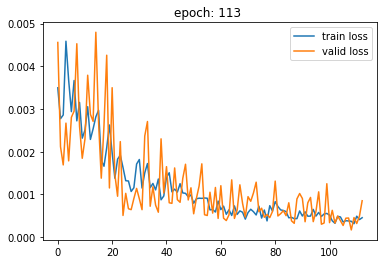

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 114  Train Loss: 0.0004  Valid Loss: 0.0005
--------------------------------------------------


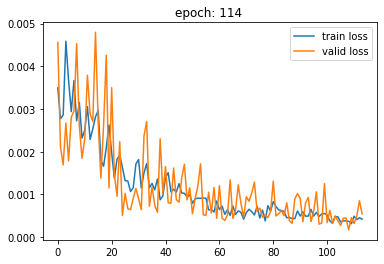

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 115  Train Loss: 0.0004  Valid Loss: 0.0003
--------------------------------------------------


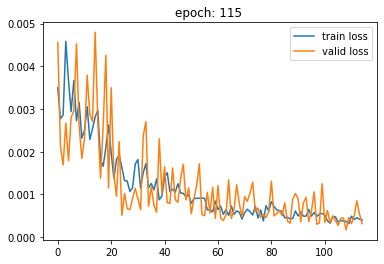

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 116  Train Loss: 0.0004  Valid Loss: 0.0006
--------------------------------------------------


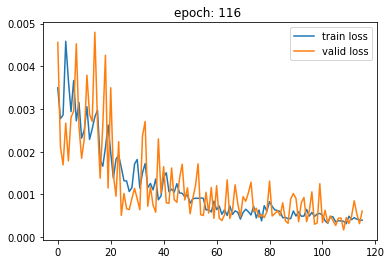

Valid Steps: 5/5  Loss: 0.0008 
--------------------------------------------------
Epoch: 117  Train Loss: 0.0003  Valid Loss: 0.0008
--------------------------------------------------


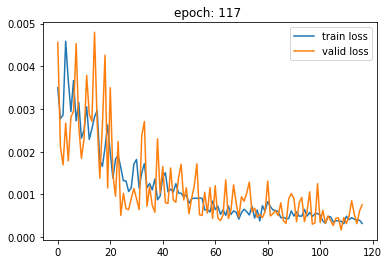

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 118  Train Loss: 0.0004  Valid Loss: 0.0002
--------------------------------------------------


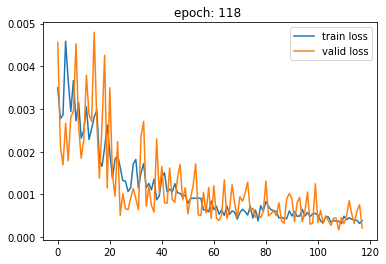

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 119  Train Loss: 0.0004  Valid Loss: 0.0005
--------------------------------------------------


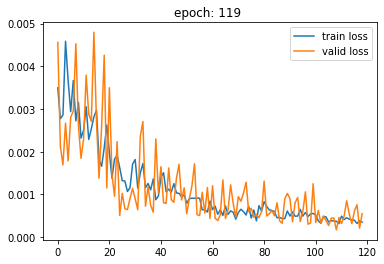

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 120  Train Loss: 0.0004  Valid Loss: 0.0005
--------------------------------------------------


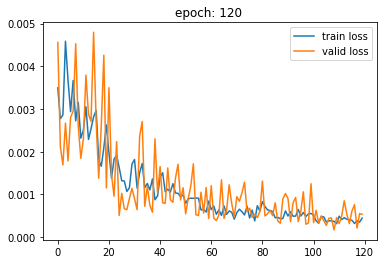

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 121  Train Loss: 0.0003  Valid Loss: 0.0004
--------------------------------------------------


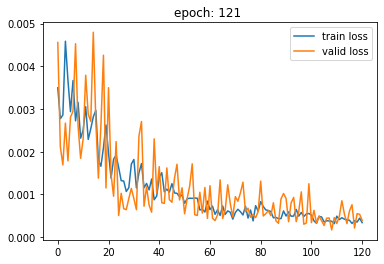

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 122  Train Loss: 0.0003  Valid Loss: 0.0006
--------------------------------------------------


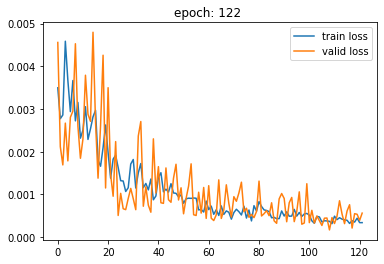

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 123  Train Loss: 0.0003  Valid Loss: 0.0002
--------------------------------------------------


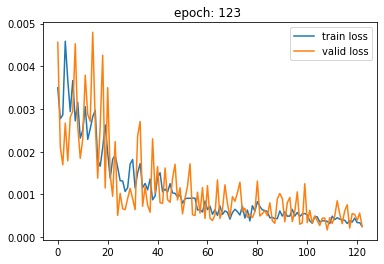

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 124  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


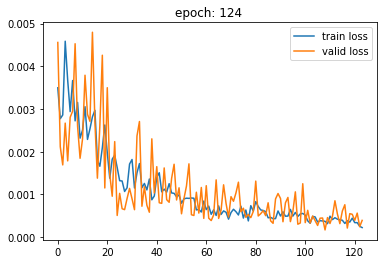

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 125  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


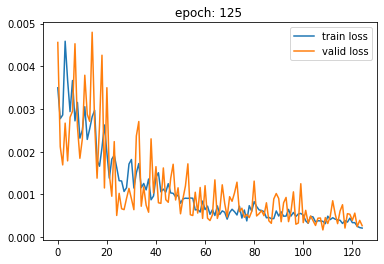

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 126  Train Loss: 0.0003  Valid Loss: 0.0005
--------------------------------------------------


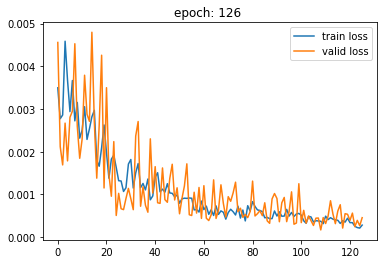

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 127  Train Loss: 0.0003  Valid Loss: 0.0004
--------------------------------------------------


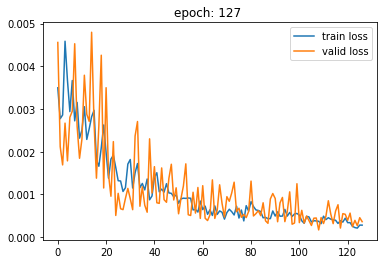

Valid Steps: 5/5  Loss: 0.0009 
--------------------------------------------------
Epoch: 128  Train Loss: 0.0003  Valid Loss: 0.0009
--------------------------------------------------


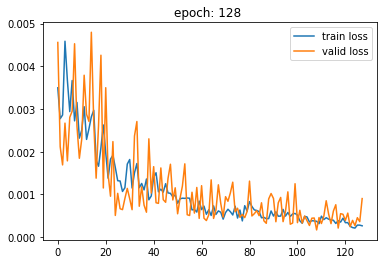

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 129  Train Loss: 0.0003  Valid Loss: 0.0004
--------------------------------------------------


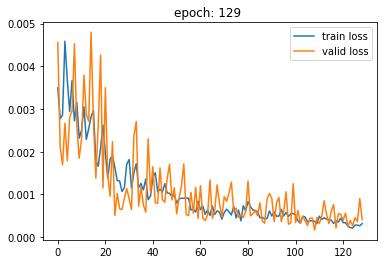

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 130  Train Loss: 0.0003  Valid Loss: 0.0003
--------------------------------------------------


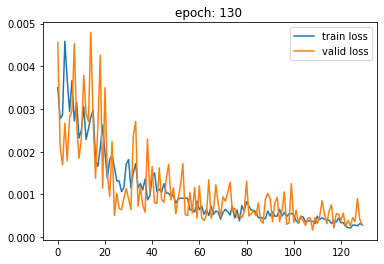

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 131  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


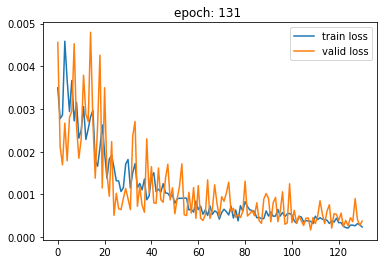

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 132  Train Loss: 0.0002  Valid Loss: 0.0005
--------------------------------------------------


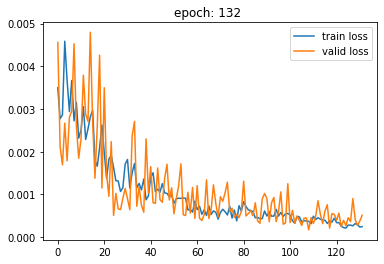

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 133  Train Loss: 0.0003  Valid Loss: 0.0005
--------------------------------------------------


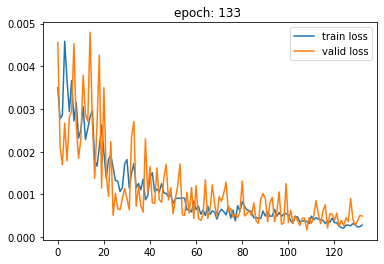

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 134  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


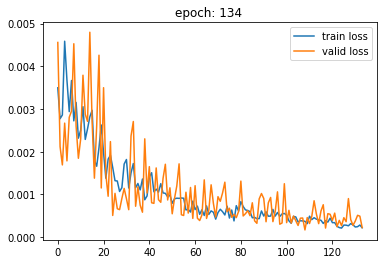

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 135  Train Loss: 0.0003  Valid Loss: 0.0005
--------------------------------------------------


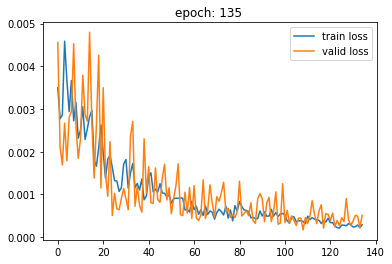

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 136  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


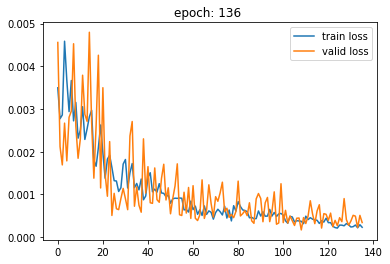

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 137  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


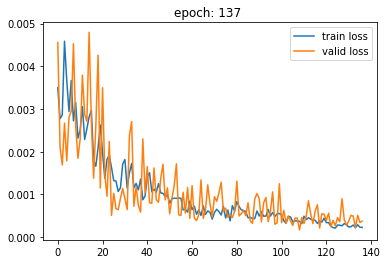

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 138  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


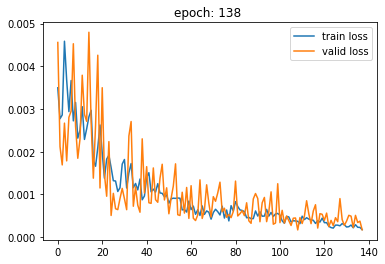

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 139  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


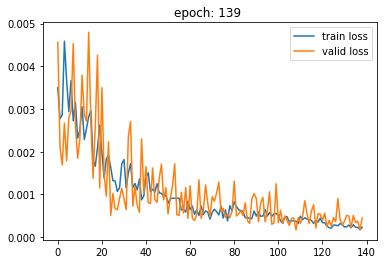

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 140  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


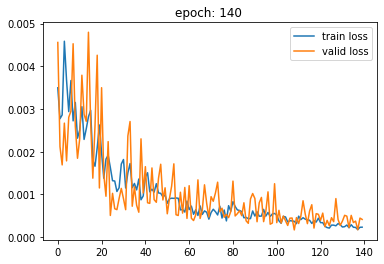

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 141  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


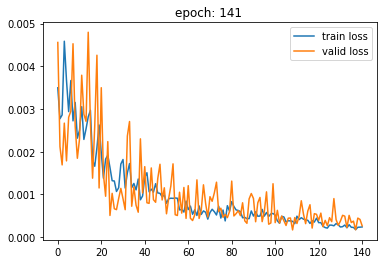

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 142  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


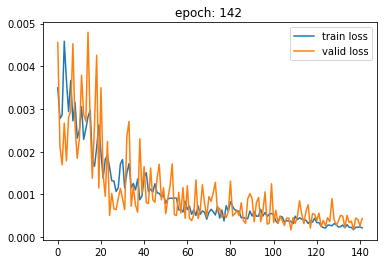

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 143  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


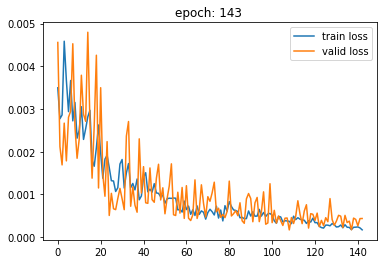

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 144  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


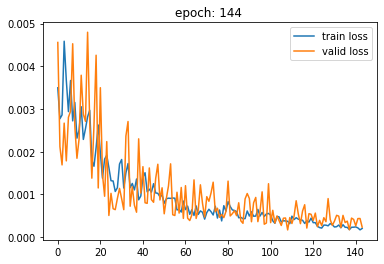

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 145  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


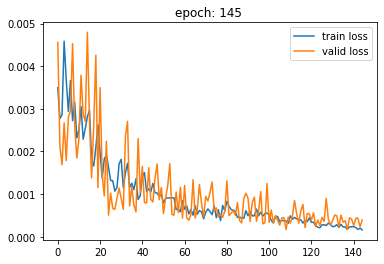

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 146  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


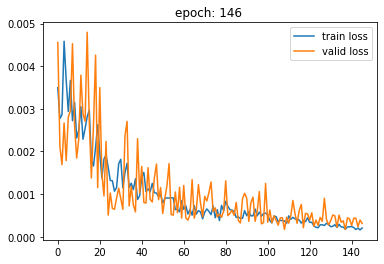

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 147  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


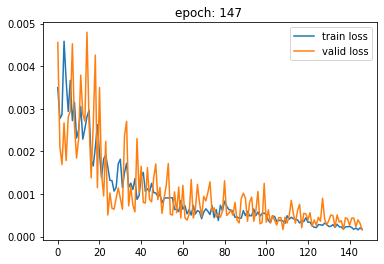


Minimum Validation Loss of 0.0002 at epoch 147/200
Model Saved

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 148  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


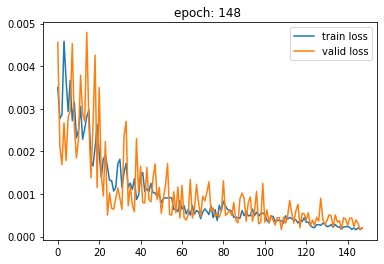

Valid Steps: 5/5  Loss: 0.0006 
--------------------------------------------------
Epoch: 149  Train Loss: 0.0002  Valid Loss: 0.0006
--------------------------------------------------


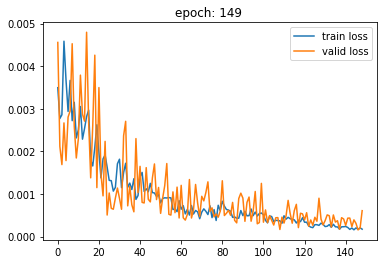

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 150  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


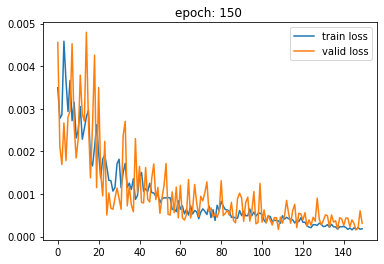

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 151  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


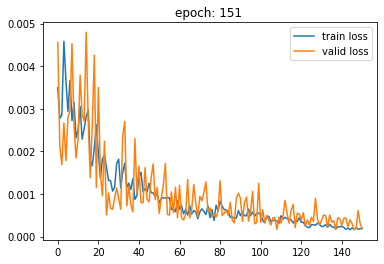

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 152  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


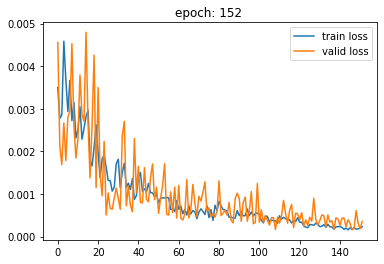

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 153  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


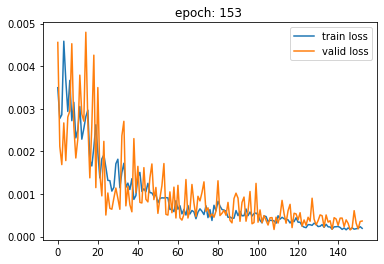

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 154  Train Loss: 0.0003  Valid Loss: 0.0003
--------------------------------------------------


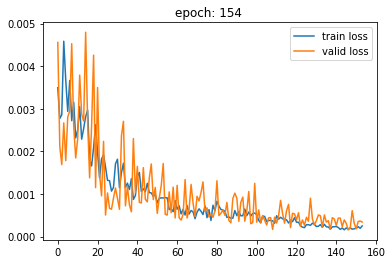

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 155  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


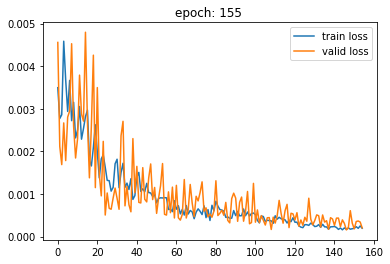

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 156  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


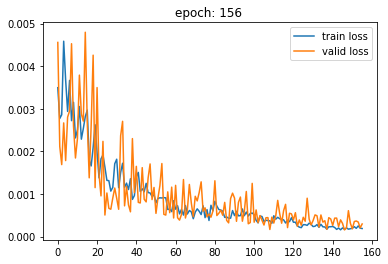

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 157  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


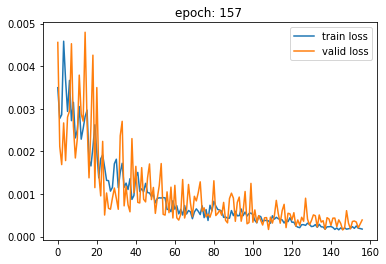

Valid Steps: 5/5  Loss: 0.0005 
--------------------------------------------------
Epoch: 158  Train Loss: 0.0002  Valid Loss: 0.0005
--------------------------------------------------


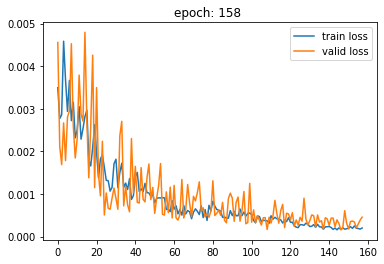

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 159  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


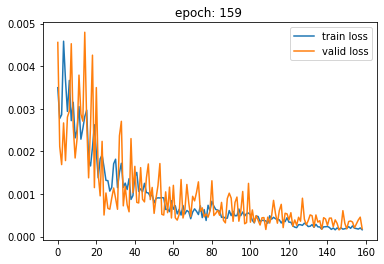

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 160  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


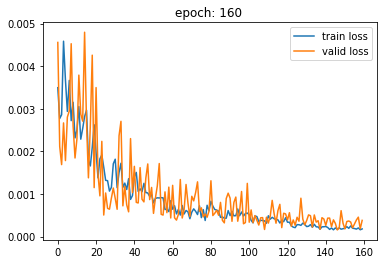

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 161  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


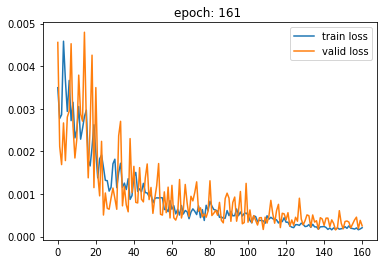

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 162  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


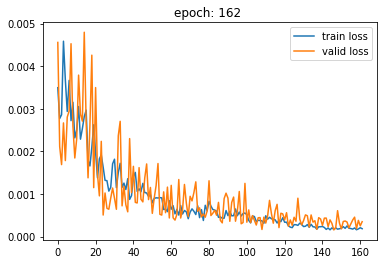

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 163  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


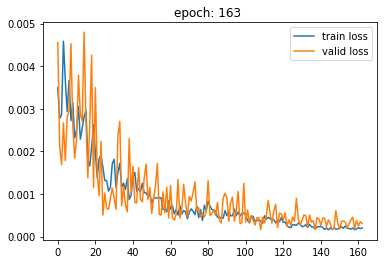

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 164  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


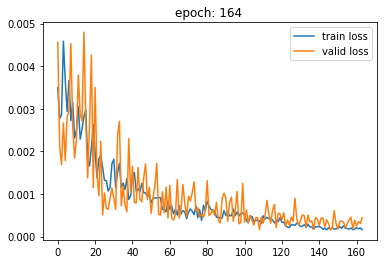

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 165  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


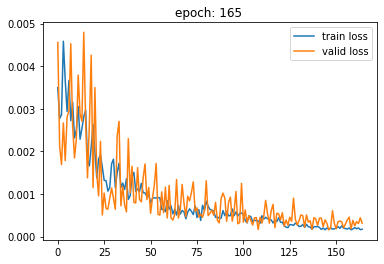

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 166  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


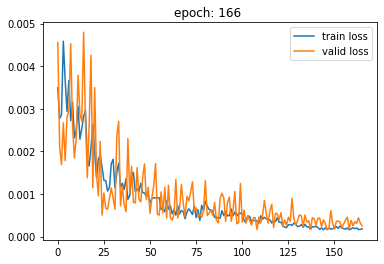

Valid Steps: 5/5  Loss: 0.0001 
--------------------------------------------------
Epoch: 167  Train Loss: 0.0002  Valid Loss: 0.0001
--------------------------------------------------


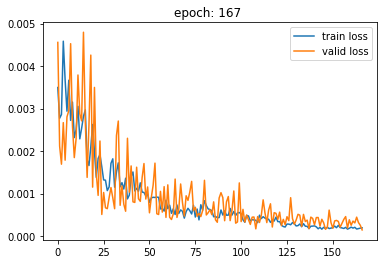


Minimum Validation Loss of 0.0001 at epoch 167/200
Model Saved

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 168  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


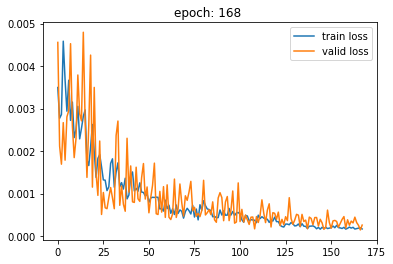

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 169  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


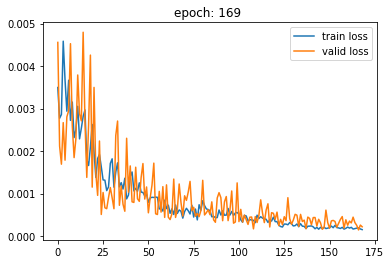

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 170  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


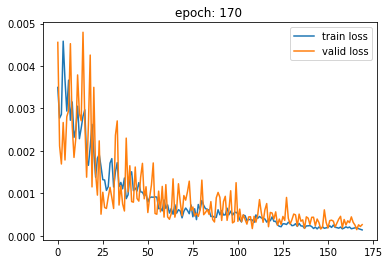

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 171  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


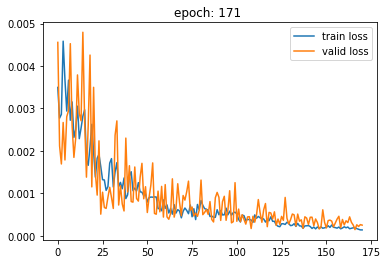

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 172  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


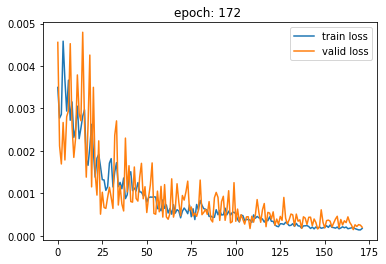

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 173  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


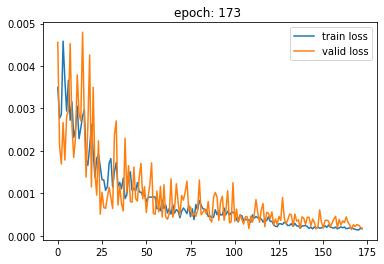

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 174  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


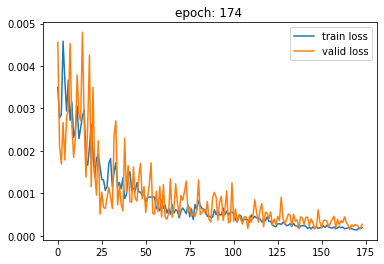

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 175  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


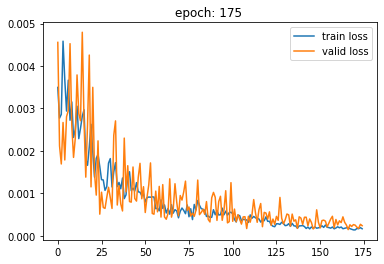

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 176  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


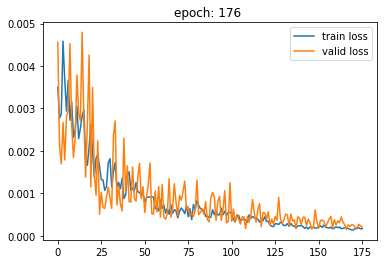

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 177  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


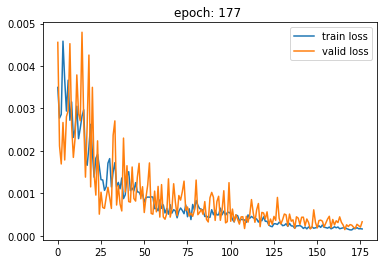

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 178  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


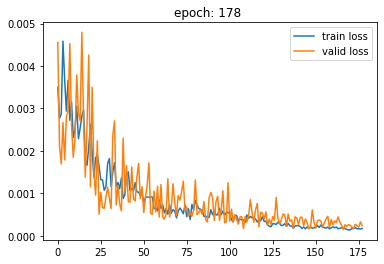

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 179  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


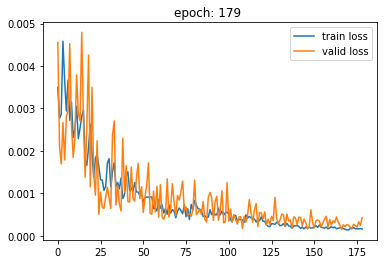

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 180  Train Loss: 0.0002  Valid Loss: 0.0003
--------------------------------------------------


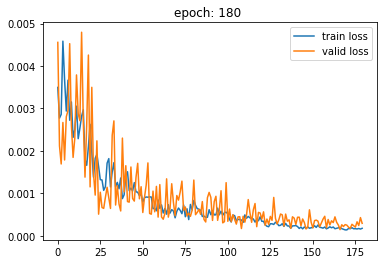

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 181  Train Loss: 0.0002  Valid Loss: 0.0004
--------------------------------------------------


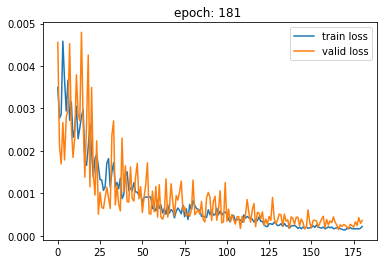

Train Steps: 8/53  Loss: 0.0002 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-u3i5fgiv'


Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 182  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


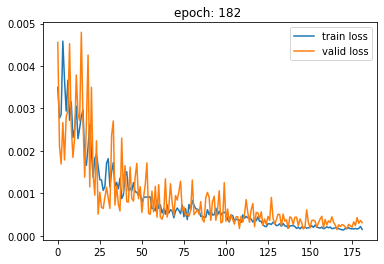

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 183  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


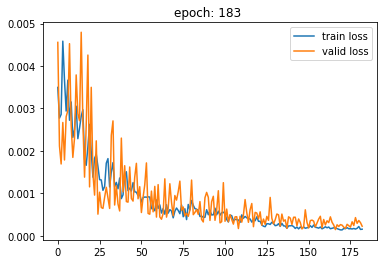

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 184  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


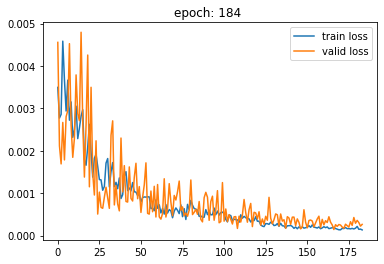

Valid Steps: 5/5  Loss: 0.0004 
--------------------------------------------------
Epoch: 185  Train Loss: 0.0001  Valid Loss: 0.0004
--------------------------------------------------


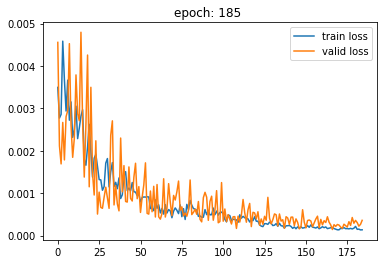

Valid Steps: 5/5  Loss: 0.0001 
--------------------------------------------------
Epoch: 186  Train Loss: 0.0001  Valid Loss: 0.0001
--------------------------------------------------


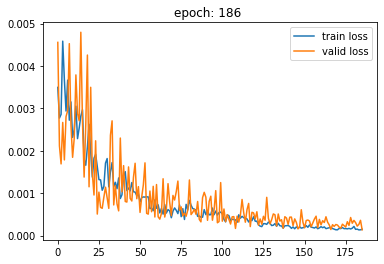


Minimum Validation Loss of 0.0001 at epoch 186/200
Model Saved

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 187  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


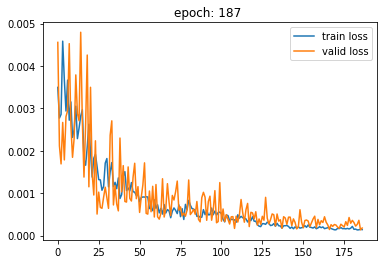

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 188  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


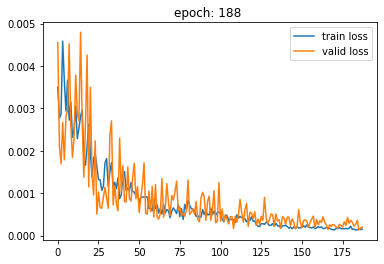

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 189  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


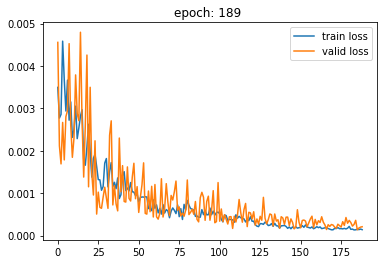

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 190  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


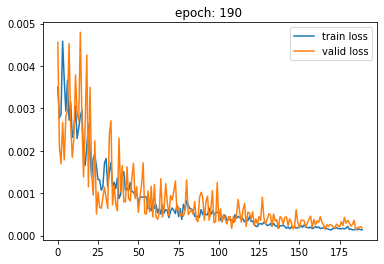

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 191  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


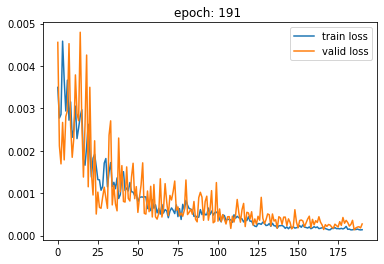

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 192  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


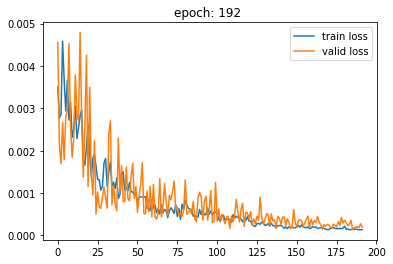

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 193  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


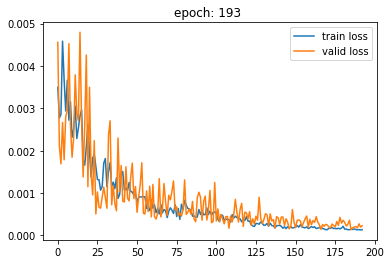

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 194  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


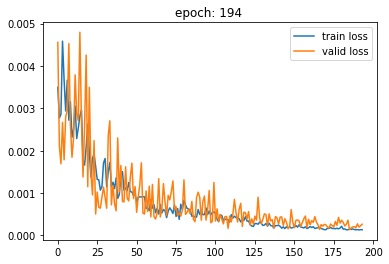

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 195  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


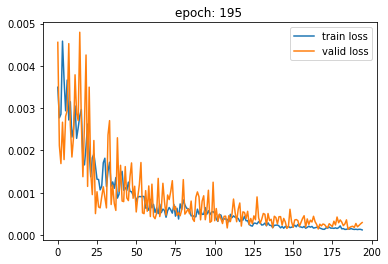

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 196  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


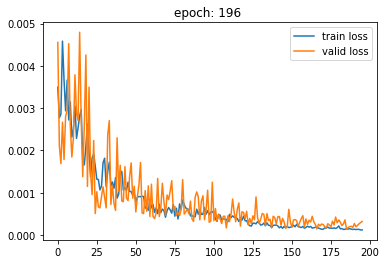

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 197  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


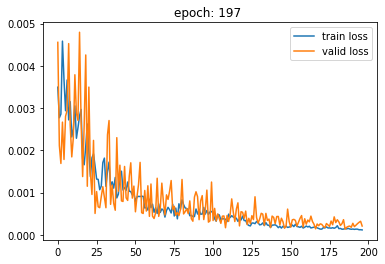

Valid Steps: 5/5  Loss: 0.0003 
--------------------------------------------------
Epoch: 198  Train Loss: 0.0001  Valid Loss: 0.0003
--------------------------------------------------


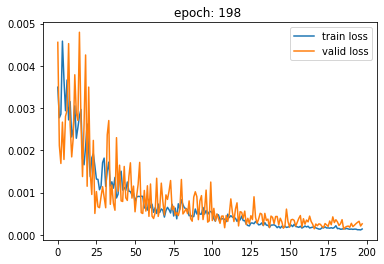

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 199  Train Loss: 0.0002  Valid Loss: 0.0002
--------------------------------------------------


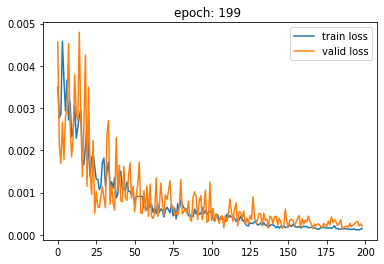

Valid Steps: 5/5  Loss: 0.0002 
--------------------------------------------------
Epoch: 200  Train Loss: 0.0001  Valid Loss: 0.0002
--------------------------------------------------


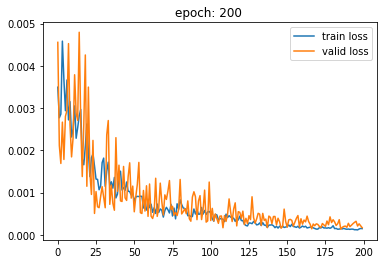

Training Complete
Total Elapsed Time : 4340.729120731354 s


In [ ]:
start_time = time.time()
loss_train_list =[]
loss_valid_list=[]
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        landmarks = landmarks.type(torch.cuda.FloatTensor)
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    scheduler.step(loss_valid)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_train_list.append(loss_train)
    loss_valid_list.append(loss_valid)
    plt.plot(loss_train_list,label='train loss')
    plt.plot(loss_valid_list,label='valid loss')

    plt.legend(loc='upper right')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)
    
    if loss_valid < loss_min:     
      loss_min = loss_valid
      torch.save(network.state_dict(), '/content/drive/MyDrive/IXIDB_axial_model_save/face_landmarks.pth') 
      print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
      print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Total number of test images: 37
Elapsed Time : 4.316283702850342


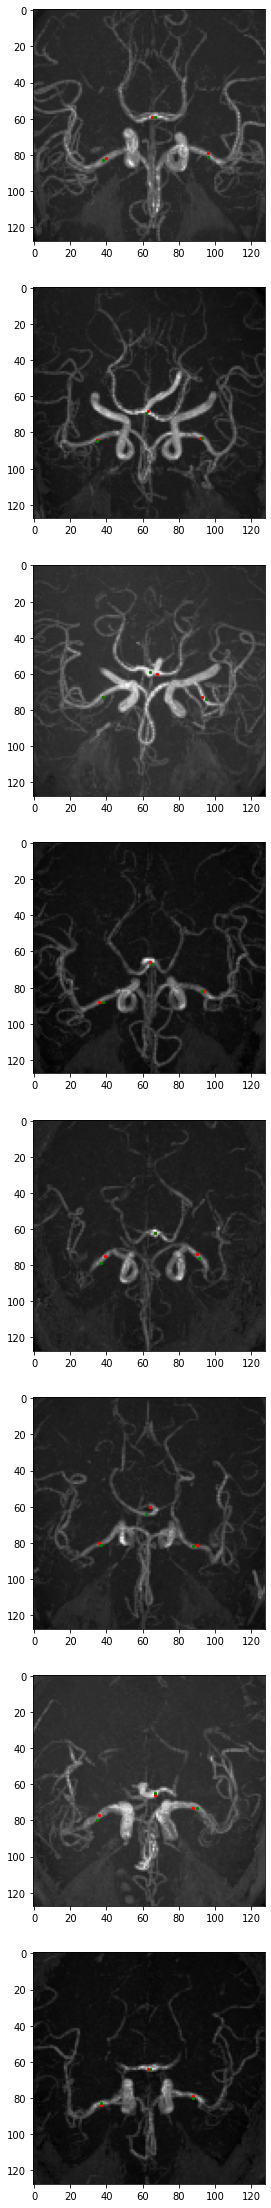

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/drive/MyDrive/IXIDB_axial_model_save/face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 128

    predictions = (best_network(images).cpu() + 0.5) * 128
    predictions = predictions.view(-1,3,2)
    predictions = torch.round(predictions)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(dataset_valid)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 